# Dependencies

In [1]:
pacman::p_load(igraph, graphlayouts, ggraph, ggforce, dplyr, ggplot2, GUniFrac, 
dendextend, ComplexHeatmap, ANCOMBC, TreeSummarizedExperiment)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [3]:
gliph_div.fx <- function(datapath, h4hpath, gliph_in_out){
gliph_all <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", gliph_in_out))
gliph_meta <- merge(gliph_all, discovery_metadata, by.x = "subject", by.y = "sample_name")
gliph_meta$disease[ is.na(gliph_meta$disease)] <- "Emerson_unknown"
pat_type <- as.data.frame.matrix(table(gliph_meta %>% select(type, subject)))
return(pat_type)
}

In [4]:
zicoseq.fx <- function(pat_type_matrix, metadata, myvar) {
    # pat_type_matrix is a matrix of GLIPH x samples
    # metadata is a data frame with the metadata for each sample, rownames are the sample names, NA is converted to Unknown for all covariates

    # Match colnames mylist[[1]] and discovery_metadata$sample_name
    metadata_matched <- metadata[colnames(pat_type_matrix), ]

    ZicoSeq.obj <- ZicoSeq(
        meta.dat = metadata_matched, feature.dat = pat_type_matrix,
        grp.name = myvar, adj.name = c("Sex", "study", "Agegroup"), feature.dat.type = "count",
        prev.filter = 0, mean.abund.filter = 0,
        max.abund.filter = 0, min.prop = 0,
        # Winsorization to replace outliers
        is.winsor = FALSE, # outlier.pct = 0.03, winsor.end = 'top',
        # Posterior sampling
        is.post.sample = TRUE, post.sample.no = 25,
        # Use the square-root transformation
        link.func = list(function(x) x^0.5), stats.combine.func = max,
        # Permutation-based multiple testing correction
        perm.no = 99, strata = NULL,
        # Reference-based multiple stage normalization
        ref.pct = 0.5, stage.no = 6, excl.pct = 0.2,
        # Family-wise error rate control
        is.fwer = TRUE, verbose = TRUE, return.feature.dat = TRUE
    )

    r2_fdr <- as.data.frame(ZicoSeq.obj$R2)
    r2_fdr$padj <- ZicoSeq.obj$p.adj.fdr[match(rownames(r2_fdr), names(ZicoSeq.obj$p.adj.fdr))]
    return(r2_fdr)
}


# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/run_gliph/"

# Main

In [7]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [8]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [9]:
gliph_out <- readr::read_csv(paste0(h4hpath, "int_vdj_gliphinput_cluster.csv"), col_names = T)

Rows: 21491 Columns: 29
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (17): pattern, type, TcRb, V, J, Sample, HLA-A, HLA-B, HLA-C, HLA-DPA1, ...
dbl (11): index, Fisher_score, number_subject, number_unique_cdr3, final_sco...
lgl  (1): TcRa

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [11]:
# tmp <- gliph_out[gliph_out$number_subject >= 3,]
tmp <- gliph_out[gliph_out$number_unique_cdr3 >= 3,]
#tmp <- tmp[tmp$Fisher_score < 0.001,]
# tmp <- tmp[tmp$expansion_score < 0.01,]
# tmp <- tmp[tmp$length_score < 0.002,]

# ANCOMBC

In [12]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(tmp %>% select(pattern, Sample)))

In [13]:
head(pat_type)

,CHP_10YO_M:X00_PBMC,CHP_15YO_F_B:X00_PBMC,CHP_15YO_M:X00_PBMC,CHP_1YO_M_A:X00_PBMC,CHP_1YO_M_B:X00_PBMC,CHP_2YO_M:X00_PBMC,CHP_323:X03_PBMC,CHP_323:X03_cfDNA,CHP_323:X05_PBMC,CHP_323:X05_cfDNA,...,LFS_TCR_4570:X00_PBMC,LFS_TCR_4602:X00_PBMC,LFS_TCR_4758:X00_PBMC,LFS_TCR_4759:X00_PBMC,LFS_TCR_4783:X00_PBMC,LFS_TCR_4837:X00_PBMC,LFS_TCR_4838:X00_PBMC,LFS_TCR_5014:X00_PBMC,LFS_TCR_5067:X00_PBMC,M.tuberculosis:CFP10_TAAQAAVVRFQEAAN
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AGTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANYG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ASGSYE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSLNTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSNQP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
meta_div$samplename <- paste0(meta_div$Patient, ":", meta_div$cycle, "_", meta_div$sampletype)

In [15]:
mytmp <- meta_div#[ meta_div$sampletype == "cfDNA",]

In [208]:
mytmp <- mytmp[ mytmp$cycle == "X01",]
# mytmp <- mytmp[ mytmp$cycle != "X04",]

In [16]:
table(mytmp$cycle)


X00 X01 X02 X03 X04 X05 
 41  99 109  98  79  78 

In [17]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% mytmp$samplename ]
# match metadata to the matrix
metadata_matched <- mytmp[match(colnames(pat_type), mytmp$samplename), ]

In [18]:
head(pat_type)

,CHP_10YO_M:X00_PBMC,CHP_15YO_F_B:X00_PBMC,CHP_15YO_M:X00_PBMC,CHP_1YO_M_A:X00_PBMC,CHP_1YO_M_B:X00_PBMC,CHP_2YO_M:X00_PBMC,CHP_323:X03_PBMC,CHP_323:X03_cfDNA,CHP_323:X05_PBMC,CHP_323:X05_cfDNA,...,LFS_TCR_4535:X00_PBMC,LFS_TCR_4570:X00_PBMC,LFS_TCR_4602:X00_PBMC,LFS_TCR_4758:X00_PBMC,LFS_TCR_4759:X00_PBMC,LFS_TCR_4783:X00_PBMC,LFS_TCR_4837:X00_PBMC,LFS_TCR_4838:X00_PBMC,LFS_TCR_5014:X00_PBMC,LFS_TCR_5067:X00_PBMC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AGTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANYG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ASGSYE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSLNTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSNQP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Make rowData

In [19]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph
# gliphdf$Class <- onetest$hklust[match(rownames(gliphdf), onetest$Xpattern)]

In [20]:
head(gliphdf)

,gliph
,<chr>
%AGTE,%AGTE
%ANE,%ANE
%ANYG,%ANYG
%ASGSYE,%ASGSYE
%DSLNTE,%DSLNTE
%DSNQP,%DSNQP


In [21]:
# gliphdf$Firstpattern <- NA
# gliphdf$cluster_size <- NA
# gliphdf$Patterns <- NA

# for (i in 1:nrow(gliphdf)) {
#     gliphdf$Firstpattern[i] <- onetest$Xpattern[onetest$hklust == gliphdf$Class[i]][1] # just the first pattern
#     gliphdf$cluster_size[i] <- length(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]]) ) # cluster size
#     gliphdf$Patterns[i] <- paste(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]] ) , collapse = ",")  # append all patterns for later inspection
# }


In [22]:
dim(gliphdf)

[1] 1527    1

Create TreeSummarizedExperiment to input to ANCOMBC

In [23]:
metadata_matched$cancergroup <- factor(metadata_matched$cancergroup, levels = c("Leukemia", "Lymphoma", "Solid tumors", "Normal", "LFS"))

In [24]:
onetest_tse <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [25]:
dim(pat_type)

[1] 1527  354

In [26]:
head(pat_type)

,CHP_10YO_M:X00_PBMC,CHP_15YO_F_B:X00_PBMC,CHP_15YO_M:X00_PBMC,CHP_1YO_M_A:X00_PBMC,CHP_1YO_M_B:X00_PBMC,CHP_2YO_M:X00_PBMC,CHP_323:X03_PBMC,CHP_323:X03_cfDNA,CHP_323:X05_PBMC,CHP_323:X05_cfDNA,...,LFS_TCR_4535:X00_PBMC,LFS_TCR_4570:X00_PBMC,LFS_TCR_4602:X00_PBMC,LFS_TCR_4758:X00_PBMC,LFS_TCR_4759:X00_PBMC,LFS_TCR_4783:X00_PBMC,LFS_TCR_4837:X00_PBMC,LFS_TCR_4838:X00_PBMC,LFS_TCR_5014:X00_PBMC,LFS_TCR_5067:X00_PBMC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AGTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ANYG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ASGSYE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSLNTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%DSNQP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
colnames(metadata_matched)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "CD3"               
[10] "EM"                 "CM"                 "Na\303\257ve"      
[13] "SCM"                "TE"                 "EM%"               
[16] "CM%"                "Na\303\257ve%"      "SCM%"              
[19] "TE%"                "Na\303\257ve/TE"    "N+CM+SCM/TE+EM"    
[22] "PD-1"               "PDL1"               "LAG3"              
[25] "TIM3"               "CTLA4"              "PD1%"              
[28] "PDL1%"              "LAG3%"              "TIM3%"             
[31] "CTLA4%"             "Any NCR"            "PD1 + LAG3 + TIM3" 
[34] "cancergroup"        "agegroup"           "foldgroup"         
[37] "Remission"          "Relapse"            "Transplant"        
[40] "CART"               "TRB"                "Reads"             
[43] "CPKR"               "Average_reads"      "VMR"               
[46] "Max_reads"          "Singletons"         "Doubletons"        
[49] "qD"                 "Sample_Coverage"    "observed_Richness" 
[52] "estimated_Richness" "SE_Richeness"       "observed_Shannon"  
[55] "estimated_Shannon"  "SE_Shannon"         "observed_Simpson"  
[58] "estimated_Simpson"  "SE_Simpson"         "basename"          
[61] "file"               "Group"              "sampletype"        
[64] "log10shann"         "samplename"

In [28]:
set.seed(111)

In [29]:
table(metadata_matched$sampletype, useNA = "ifany")


 PBMC Tumor cfDNA 
  202    12   140 

In [34]:
out <- ancombc2(
    data = onetest_tse, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "cancergroup + sampletype", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "cancergroup", 
    struc_zero = TRUE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 2, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


`tax_level` is not speficified 
No agglomeration will be performed
Otherwise, please speficy `tax_level` by one of the following: 


Obtaining initial estimates ...

ML iteration = 1, epsilon = 0.038

ML iteration = 2, epsilon = 1.2e-15

Estimating sample-specific biases ...

ANCOM-BC2 primary results ...

The sensitivity analysis for the pseudo-count addition ...

ANCOM-BC2 global test ...

ANCOM-BC2 pairwise directional test ...

ANCOM-BC2 Dunnet's type of test ...



In [35]:
myres <- out$res

In [36]:
(myres)

taxon,lfc_(Intercept),lfc_cancergroupLymphoma,lfc_cancergroupSolid tumors,lfc_cancergroupNormal,lfc_cancergroupLFS,lfc_sampletypeTumor,lfc_sampletypecfDNA,se_(Intercept),se_cancergroupLymphoma,...,q_cancergroupLFS,q_sampletypeTumor,q_sampletypecfDNA,diff_(Intercept),diff_cancergroupLymphoma,diff_cancergroupSolid tumors,diff_cancergroupNormal,diff_cancergroupLFS,diff_sampletypeTumor,diff_sampletypecfDNA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
S%TDT,0.007315555,-0.007807805,-0.008128259,-0.011229207,-0.011229217,-0.003101064,-0.007803314,0.005815144,0.009824808,...,0.7478519,0.9252771,0.5129288,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
SP%NTGE,0.003656669,-0.003902954,-0.004063874,-0.005612279,-0.005612289,-0.001548520,-0.003899777,0.004779826,0.008075616,...,0.7478519,0.9252771,0.5129288,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [47]:
myres[ myres$diff_disease_groupLymphoma == "TRUE",]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


taxon,lfc_(Intercept),lfc_cancergroupLymphoma,lfc_cancergroupSolid tumors,lfc_cancergroupNormal,lfc_cancergroupLFS,lfc_cycleX01,lfc_cycleX02,lfc_cycleX03,lfc_cycleX04,...,diff_(Intercept),diff_cancergroupLymphoma,diff_cancergroupSolid tumors,diff_cancergroupNormal,diff_cancergroupLFS,diff_cycleX01,diff_cycleX02,diff_cycleX03,diff_cycleX04,diff_cycleX05
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


# Backup

In [7]:
discovery_metadata <- readr::read_rds(file = paste0(datapath, "discovery_metadata_01.rds"))
discovery_metadata$disease[ is.na(discovery_metadata$disease)] <- "Emerson_unknown"

In [8]:
dim(discovery_metadata)

[1] 973   8

In [9]:
table(discovery_metadata$disease)


                Ctrl    Cytomegalovirus +    Cytomegalovirus - 
                  94                  284                  346 
     Emerson_unknown                   KD                  LFS 
                  24                    4                    6 
            Leukemia             Lymphoma                  MAS 
                  36                   13                    3 
   MIS-C SARSCoV2Neg    MIS-C SARSCoV2Pos               Normal 
                   2                    2                    8 
        Peds COVID19 Peds febrile Control Peds healthy Control 
                   3                    5                    3 
               Solid                  T1D                 sJIA 
                  28                  109                    3 

In [10]:
# remove non normal non cancer samples
discovery_metadata <- discovery_metadata[!discovery_metadata$disease %in%
    c(
        "KD", "MAS", "LFS", "Emerson_unknown",
        "MIS-C SARSCoV2Neg", "sJIA"
    ), ]


In [11]:
table(discovery_metadata$disease)


                Ctrl    Cytomegalovirus +    Cytomegalovirus - 
                  94                  284                  346 
            Leukemia             Lymphoma    MIS-C SARSCoV2Pos 
                  36                   13                    2 
              Normal         Peds COVID19 Peds febrile Control 
                   8                    3                    5 
Peds healthy Control                Solid                  T1D 
                   3                   28                  109 

In [12]:
# make a new variable for the disease
# Group Leukemia, Lymphoma and Solid together as Cancer
discovery_metadata$disease_group <- discovery_metadata$disease

discovery_metadata$disease_group[discovery_metadata$disease %in% c("Leukemia", "Lymphoma", "Solid")] <- "Cancer"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("Ctrl", # from Mitchell
                                                                    "Peds healthy Control", # from Henderson
                                                                    "Peds febrile Control", # from Henderson
                                                                    "Cytomegalovirus -", # from Emerson
                                                                    "Normal" # from INTERCEPT
                                                                    )] <- "Healthy"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("MIS-C SARSCoV2Pos", # from Henderson
                                                                    "Peds COVID19", # from Henderson
                                                                    "Cytomegalovirus +" # from Emerson
                                                                    )] <- "Viral"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("T1D")] <- "T1D" # from Mitchell

In [13]:
table(discovery_metadata$disease)


                Ctrl    Cytomegalovirus +    Cytomegalovirus - 
                  94                  284                  346 
            Leukemia             Lymphoma    MIS-C SARSCoV2Pos 
                  36                   13                    2 
              Normal         Peds COVID19 Peds febrile Control 
                   8                    3                    5 
Peds healthy Control                Solid                  T1D 
                   3                   28                  109 

In [14]:
discovery_metadata$Sex[ is.na(discovery_metadata$Sex)] <- "Unknown"
discovery_metadata$Agegroup[ is.na(discovery_metadata$Agegroup)] <- "Unknown"

In [15]:
table(discovery_metadata$disease_group, useNA = "ifany")


 Cancer Healthy     T1D   Viral 
     77     456     109     289 

In [16]:
discovery_metadata$Sex <- factor(discovery_metadata$Sex, levels = c("Female", "Male", "Unknown"))
discovery_metadata$Agegroup <- factor(discovery_metadata$Agegroup, levels = c("Neonate", "Child", "Adolescent", "Young Adult", "Adult", "Senior", "Unknown") )
#discovery_metadata$study <- factor(discovery_metadata$study, levels = c("Emerson", "Henderson", "INTERCEPT", "Mitchell"))
#discovery_metadata$disease_group <- factor(discovery_metadata$disease_group, levels = c("Healthy", "Viral", "Cancer", "T1D"))

In [17]:
head(discovery_metadata)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>
21,Peds_Ctrl_2,NA,PBMC,Henderson,Child,Unknown,Peds healthy Control,Peds_Ctrl_2,Healthy
23,Peds_Febrile_Ctrl_3,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_3,Healthy
30,MIS-C_SARSCoV2Pos_12,NA,PBMC,Henderson,Child,Unknown,MIS-C SARSCoV2Pos,MIS-C_SARSCoV2Pos_12,Viral
34,Peds_COVID19_02,NA,PBMC,Henderson,Child,Unknown,Peds COVID19,Peds_COVID19_02,Viral
35,MIS-C_SARSCoV2Pos_13,NA,PBMC,Henderson,Child,Unknown,MIS-C SARSCoV2Pos,MIS-C_SARSCoV2Pos_13,Viral
41,Peds_Febrile_Ctrl_5,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_5,Healthy


In [18]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [43]:
head(myres)

,taxon,lfc_(Intercept),lfc_disease_groupCancer,lfc_Age,se_(Intercept),se_disease_groupCancer,se_Age,W_(Intercept),W_disease_groupCancer,W_Age,p_(Intercept),p_disease_groupCancer,p_Age,q_(Intercept),q_disease_groupCancer,q_Age,diff_(Intercept),diff_disease_groupCancer,diff_Age
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,GXGEK,3.874582e-06,2.482338e-06,-1.330490e-07,2.802819e-05,0.0000572233,8.074706e-07,0.1382387,0.04337985,-0.1647726,0.8900517,0.9653987,0.86912300,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE
2,GXNTE,-4.390254e-03,-4.745997e-04,1.787385e-04,5.047142e-03,0.0103044739,1.454051e-04,-0.8698497,-0.04605763,1.2292450,0.3843826,0.9632643,0.21897994,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE
3,GXTE,3.874582e-06,2.482338e-06,-1.330490e-07,2.802819e-05,0.0000572233,8.074706e-07,0.1382387,0.04337985,-0.1647726,0.8900517,0.9653987,0.86912300,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE
4,NXE,-5.374825e-03,1.977709e-03,1.963677e-04,3.561871e-03,0.0072720783,1.026154e-04,-1.5089891,0.27195926,1.9136284,0.1313016,0.7856533,0.05566765,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE
5,RGXE,-3.253735e-03,5.018639e-04,1.249910e-04,3.571089e-03,0.0072908972,1.028809e-04,-0.9111324,0.06883431,1.2149099,0.3622256,0.9451215,0.22440045,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE
6,RQGXEK,3.874582e-06,2.482338e-06,-1.330490e-07,2.802819e-05,0.0000572233,8.074706e-07,0.1382387,0.04337985,-0.1647726,0.8900517,0.9653987,0.86912300,0.956694,0.9997286,0.9509228,FALSE,FALSE,FALSE


In [45]:
myres[ myres$diff_disease_groupCancer == "TRUE",]

,taxon,lfc_(Intercept),lfc_disease_groupCancer,lfc_Age,se_(Intercept),se_disease_groupCancer,se_Age,W_(Intercept),W_disease_groupCancer,W_Age,p_(Intercept),p_disease_groupCancer,p_Age,q_(Intercept),q_disease_groupCancer,q_Age,diff_(Intercept),diff_disease_groupCancer,diff_Age
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
25,SEGXE,-2.965303e-03,0.02866218,4.502889e-05,0.003509301,0.007164748,0.0001011008,-0.84498394,4.000444,0.4453859,0.3981198,6.322365e-05,0.6560409,0.9566940,0.005879799,0.9509228,FALSE,TRUE,FALSE
67,SLXGAGANV,-1.229866e-03,0.02745467,-1.337017e-05,0.003510062,0.007166302,0.0001011228,-0.35038294,3.831079,-0.1322172,0.7260513,1.275825e-04,0.8948125,0.9566940,0.006179623,0.9676461,FALSE,TRUE,FALSE
89,SPXRNTE,-7.290763e-05,0.02664966,-5.230288e-05,0.003509022,0.007164180,0.0001010928,-0.02077719,3.719848,-0.5173748,0.9834234,1.993427e-04,0.6048946,0.9887392,0.006179623,0.9509228,FALSE,TRUE,FALSE
94,SQDXNQP,-2.657340e-04,0.02678383,-4.581409e-05,0.003509282,0.007164709,0.0001011003,-0.07572318,3.738300,-0.4531549,0.9396393,1.852691e-04,0.6504372,0.9782048,0.006179623,0.9509228,FALSE,TRUE,FALSE
150,SXQGNQP,-3.736608e-03,0.02919885,7.098403e-05,0.003508069,0.007162233,0.0001010654,-1.06514675,4.076780,0.7023577,0.2868095,4.566369e-05,0.4824561,0.9566940,0.005879799,0.9509228,FALSE,TRUE,FALSE
174,SXVGGTE,-2.657340e-04,0.02678383,-4.581409e-05,0.003509282,0.007164709,0.0001011003,-0.07572318,3.738300,-0.4531549,0.9396393,1.852691e-04,0.6504372,0.9782048,0.006179623,0.9509228,FALSE,TRUE,FALSE


In [46]:
readr::write_rds(myres, file = paste0(datapath, "ANCOMBC2_results_test.rds"))

#### graph significant gliph groups in cancer vs healthy

In [47]:
sig_groups <- myres$taxon[ myres$diff_disease_groupCancer == "TRUE"]

In [48]:
sig_groups

[1] "SEGXE"     "SLXGAGANV" "SPXRNTE"   "SQDXNQP"   "SXQGNQP"   "SXVGGTE"

In [49]:
# subset onetest to include only those samples in the metadata
onetest_matched <- onetest[onetest$subject %in% discovery_metadata$sample_name, ]

In [50]:
head(onetest_matched)

Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.y,Xpattern,hklust
<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<lgl>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
310103_TCRB:6665,171,S%RDNTE,8.8e-05,10,8,1.5e-08,1,0.13,0.130,...,TRBV19-01,TRBJ01-01,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,6665,SXRDNTE,3
310104_TCRB:6701,16,S%SGNT,2.4e-07,49,26,1.4e-09,1,1.00,0.036,...,TRBV14-01,TRBJ01-03,NA,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6701,SXSGNT,4
310104_TCRB:6708,251,S%GQP,2.1e-04,23,15,6.2e-08,1,0.99,0.660,...,TRBV19-01,TRBJ01-05,NA,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6708,SXGQP,5
310104_TCRB:6734,179,SLA%E,9.4e-05,46,25,6.8e-10,1,0.19,0.070,...,TRBV07-08,TRBJ02-01,NA,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6734,SLAXE,1
310104_TCRB:6737,231,SGQG%GE,1.8e-04,12,10,6.9e-08,1,0.30,0.740,...,TRBV18-01,TRBJ02-02,NA,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6737,SGQGXGE,6
310104_TCRB:6773,471,SP%,5.3e-04,14,13,6.1e-08,1,0.98,0.810,...,TRBV10-01,TRBJ01-03,NA,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6773,SPX,7


graph patient type

In [291]:
head(pat_type)

,310103_TCRB,310104_TCRB,310106_TCRB,310108_TCRB,310109_TCRB,310111_TCRB,310112_TCRB,310117_TCRB,310119_TCRB,310120_TCRB,...,P00649,P00656,P00665,Peds_Ctrl_1,Peds_Ctrl_2,Peds_Ctrl_7,Peds_Febrile_Ctrl_1,Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_6
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GEX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GGGGNXE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GXGEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GXGNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GXNTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GXTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix(pat_type, weighted = T )

In [289]:
gliph_data_igrf

IGRAPH fea50f1 UNWB 1182 7163 -- 
+ attr: type (v/l), name (v/c), weight (e/n)
+ edges from fea50f1 (vertex names):
 [1] GEX    --310171_TCRB         GEX    --310187_TCRB        
 [3] GEX    --P00098              GEX    --P00314             
 [5] GEX    --P00404              GEX    --P00591             
 [7] GGGGNXE--P00192              GGGGNXE--P00229             
 [9] GXGEK  --310182_TCRB         GXGEK  --310251_TCRB        
[11] GXGEK  --CHP_387-01-PBMC-DNA GXGEK  --P00057             
[13] GXGEK  --P00183              GXGEK  --P00269             
[15] GXGEK  --P00371              GXGEK  --P00534             
+ ... omitted several edges

In [301]:
V(gliph_data_igrf)$disease_group <- sapply(V(gliph_data_igrf)$name, function(x){
    discovery_metadata$disease_group[match(x, discovery_metadata$sample_name)]})

In [303]:
V(gliph_data_igrf)$sig_color <- "black"
V(gliph_data_igrf)$sig_color[ which(V(gliph_data_igrf)$name %in% sig_groups) ] <- "red"

In [317]:
myg2 <- bipartite.projection(gliph_data_igrf)$proj1

In [318]:
summary(degree(myg2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   103.0   197.5   214.4   306.2   645.0 

In [319]:
myg2 <- delete.vertices( myg2, which(degree(myg2) <= 300) )

In [320]:
set.seed(111)
pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 10, height = 10)
ggraph(myg2 , "fr") +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 2)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.2, 1))
dev.off()

Warning message:
"Removed 202 rows containing missing values (`geom_point()`)."


pdf 
  2

graph type tcr

In [321]:
gliph_data_matrix_df <- as.data.frame.matrix(table(onetest_matched %>% select(type , TcRb)))

In [322]:
head(gliph_data_matrix_df)

,ACGRGEAFF,CAAGEPQHF,CAAGNTEAFF,CAARGSGNTIYF,CAARTGGTEAFF,CAASDSNQPQHF,CAASMNTEAFF,CAASQGANTEAFF,CAASQRGNTEAFF,CAATPGLANTGELFF,...,RASTGEREQFF,RDLNTEAFF,REKSYEQYF,RRSVEAFF,RVSSYEQYF,SGGVGEKLFF,VSNTEAFF,VVSYEQYF,WFRYSGNTIYF,YVPSPTEAFF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
global-%AG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%AGTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
global-%ENTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%GE,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [323]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix(gliph_data_matrix_df, weighted = T )

In [324]:
gliph_data_igrf

IGRAPH fd94671 UNWB 5347 5491 -- 
+ attr: type (v/l), name (v/c), weight (e/n)
+ edges from fd94671 (vertex names):
 [1] global-%AG  --CASRAGYTF   global-%AG  --CASTAGYTF  
 [3] global-%AG  --CATQAGAFF   global-%AG  --CSATAGAFF  
 [5] global-%AGTE--CANRAGTEAFF global-%AGTE--CASPAGTEAFF
 [7] global-%AGTE--CASRAGTEAFF global-%AGTE--CASSAGTEAFF
 [9] global-%AGTE--CASSAGTEQYF global-%AGTE--CSARAGTEAFF
[11] global-%AGTE--CSASAGTEAFF global-%AGTE--CSATAGTEAFF
[13] global-%AGTE--CSGRAGTEAFF global-%E   --CAGFEAFF   
[15] global-%E   --CASREAFF    global-%E   --CASSELFF   
+ ... omitted several edges

In [325]:
head(V(gliph_data_igrf)$name)

[1] "global-%AG"   "global-%AGTE" "global-%E"    "global-%ENTE" "global-%G"   
[6] "global-%GE"

In [326]:
# match the subject to the TcRb
V(gliph_data_igrf)$subject <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$subject[match(x, onetest_matched$TcRb)]})

In [327]:
# match the subject to the GLIPH type
V(gliph_data_igrf)$subject[is.na(V(gliph_data_igrf)$subject)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$subject)], function(x){
    mysubj <- onetest_matched$subject[ onetest_matched$type == x  ]
    mysubj[ grepl("CHP", mysubj)][1]
})

In [328]:
onetest_matched$subject[ onetest_matched$type == "global-%AG"  ]

[1] "310173_TCRB"         "310205_TCRB"         "CHP_365-01_PBMC-DNA"
[4] "P00578"

In [329]:
onetest_matched[ onetest_matched$type == "global-%AG",]

Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.y,Xpattern,hklust
<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<lgl>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
310173_TCRB:18930,494,%AG,0.00057,4,4,1.1e-07,1,0.34,0.14,...,TRBV20-01,TRBJ01-01,NA,NA,5.085228e-06,310173_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310173_TCRB.tsv,18930,XAG,7
310205_TCRB:27623,494,%AG,0.00057,4,4,1.1e-07,1,0.34,0.14,...,TRBV07-09,TRBJ01-01,NA,NA,5.947796e-06,310205_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310205_TCRB.tsv,27623,XAG,7
CHP_365:7018,494,%AG,0.00057,4,4,1.1e-07,1,0.34,0.14,...,TRBV6-1,TRBJ1-2,NA,216,1.246372e-03,CHP_365-01_PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/remaining_batch_2_22April2021/mixcr/clones/CLONES_TRBCHP_365-01_PBMC-DNA.txt,7018,XAG,7
P00578:205809,494,%AG,0.00057,4,4,1.1e-07,1,0.34,0.14,...,TRBV05-08,TRBJ01-02,NA,25,6.698349e-06,P00578,/cluster/projects/pughlab/external_data/Adaptive/emerson2017/P00578.tsv,205809,XAG,7


In [330]:
head(V(gliph_data_igrf)$subject)

[1] "CHP_365-01_PBMC-DNA" "CHP_373-01-PBMC-DNA" "CHP_363-01_PBMC-DNA"
[4] NA                    NA                    NA

In [331]:
V(gliph_data_igrf)$disease <- sapply(V(gliph_data_igrf)$subject, function(x){
    discovery_metadata$disease[match(x, discovery_metadata$sample_name)]})


In [332]:
V(gliph_data_igrf)$disease_group <- sapply(V(gliph_data_igrf)$subject, function(x){
    discovery_metadata$disease_group[match(x, discovery_metadata$sample_name)]})

In [352]:
V(gliph_data_igrf)$disease_group[ is.na(V(gliph_data_igrf)$disease_group) ] <- "Healthy"

In [353]:

V(gliph_data_igrf)$Xpattern <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$Xpattern[match(x, onetest_matched$type)]})

In [354]:
sig_tcrs <- onetest_matched$TcRb[onetest_matched$Xpattern %in% sig_groups]

In [355]:
V(gliph_data_igrf)$Xpattern <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$Xpattern[match(x, onetest_matched$type)]})

In [356]:

#V(gliph_data_igrf)$Xpattern[is.na(V(gliph_data_igrf)$Xpattern)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$Xpattern)], function(x){
#    onetest_matched$Xpattern[match(x, onetest_matched$TcRb)]
#})

In [357]:
head(V(gliph_data_igrf)$Xpattern)

[1] "XAG"   "XAGTE" "XE"    "XENTE" "XG"    "XGE"

In [358]:
V(gliph_data_igrf)$sig_color <- "black"
V(gliph_data_igrf)$sig_color[ which(V(gliph_data_igrf)$Xpattern %in% sig_groups) ] <- "red"

In [359]:
myg2 <- (bipartite.projection(gliph_data_igrf)$proj1)

In [360]:
myg2

IGRAPH 27c0a3d UNW- 752 651 -- 
+ attr: name (v/c), subject (v/c), disease (v/c), disease_group (v/x),
| Xpattern (v/c), sig_color (v/c), weight (e/n)
+ edges from 27c0a3d (vertex names):
 [1] global-%AGTE--global-R%GTE global-%AGTE--global-S%GTE
 [3] global-%AGTE--global-SA%TE global-%E   --global-S%   
 [5] global-%E   --global-T%    global-%E   --global-P%   
 [7] global-%ENTE--global-R%NTE global-%ENTE--global-S%NTE
 [9] global-%ENTE--global-SE%TE global-%ENTE--global-G%NTE
[11] global-%G   --global-S%    global-%G   --global-P%   
[13] global-%GE  --global-S%E   global-%GGTE--global-S%GTE
+ ... omitted several edges

In [361]:
summary(degree(myg2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.731   3.000  15.000 

In [362]:
myg2 <- delete.vertices( myg2, which(degree(myg2) <= 3) )
#myg2 <- delete.vertices( myg2, which(degree(myg2) == 95) )

In [385]:
set.seed(111)
pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 5, height = 5)
ggraph(myg2 , "fr") +
geom_edge_link(edge_width = 0.04, edge_colour = "#000000") + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 2)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.4, 1)) +
geom_node_text(aes(filter = (sig_color == "red"), label = name), size = 2, repel = T, force = 100) +
theme(legend.position = "bottom")

dev.off()

pdf 
  2

In [377]:
bb <- layout_as_backbone(myg2, keep = 0.4)
E(myg2)$col <- FALSE
E(myg2)$col[bb$backbone] <- TRUE

Warning message in layout_as_backbone(myg2, keep = 0.4):
"input graph is disconnected. The algorithm works best on connected graphs and may lead to misleading results for graphs with disconnected components. Run the algorithm on each component separately and delete isolated nodes to mitigate this issue."


In [378]:
#set.seed(111)
#pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 10, height = 10)
ggraph(myg2 , layout = "manual", x = bb$xy[, 1], y = bb$xy[, 2]) +
geom_edge_link(edge_width = 0.1, aes(edge_colour = col)) + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 4)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.4, 1)) +
geom_node_text(aes(filter = (sig_color == "red"), label = name), size = 4, repel = T, force = 100) 

#dev.off()

pdf 
  2

In [250]:
myg <- (bipartite.projection(gliph_data_igrf)$proj1)

In [214]:
myg

IGRAPH 55a8a81 UNW- 752 651 -- 
+ attr: name (v/c), subject (v/c), disease (v/c), disease_group (v/x),
| Xpattern (v/c), sig_color (v/c), weight (e/n)
+ edges from 55a8a81 (vertex names):
 [1] global-%AGTE--global-R%GTE global-%AGTE--global-S%GTE
 [3] global-%AGTE--global-SA%TE global-%E   --global-S%   
 [5] global-%E   --global-T%    global-%E   --global-P%   
 [7] global-%ENTE--global-R%NTE global-%ENTE--global-S%NTE
 [9] global-%ENTE--global-SE%TE global-%ENTE--global-G%NTE
[11] global-%G   --global-S%    global-%G   --global-P%   
[13] global-%GE  --global-S%E   global-%GGTE--global-S%GTE
+ ... omitted several edges

In [215]:
myg1 <- delete_vertices( myg, degree(myg) == 0)
myk <- cluster_louvain(myg1, resolution = 1, weights = NULL)

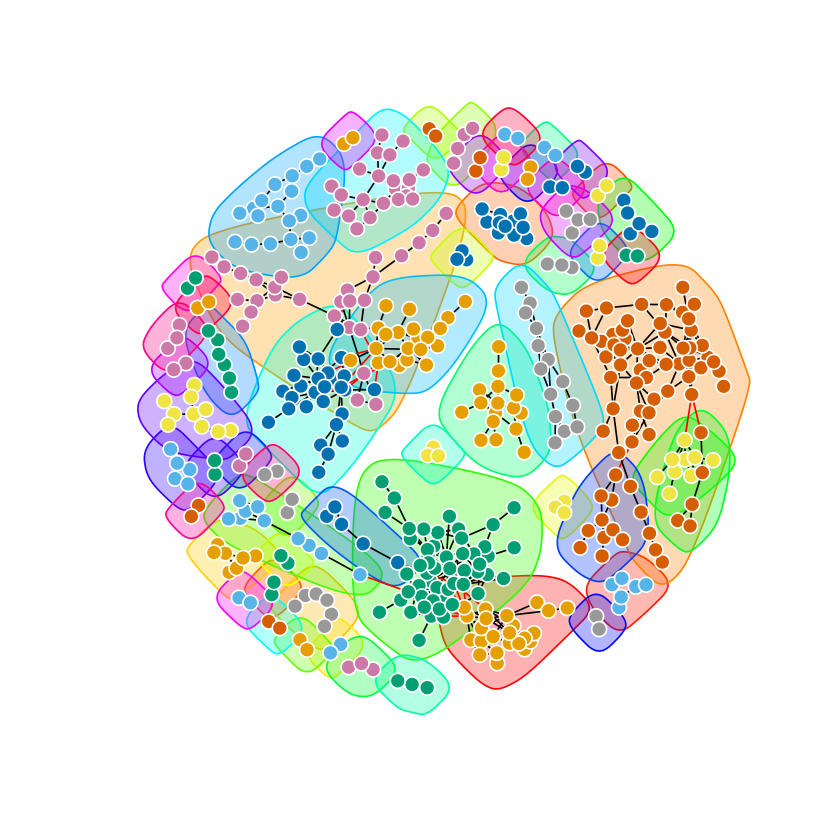

In [216]:
plot(myk, myg1, vertex.label=NA, vertex.frame.color="white", vertex.size=5)

In [217]:
V(myg1)$community <- as.character(myk$membership)

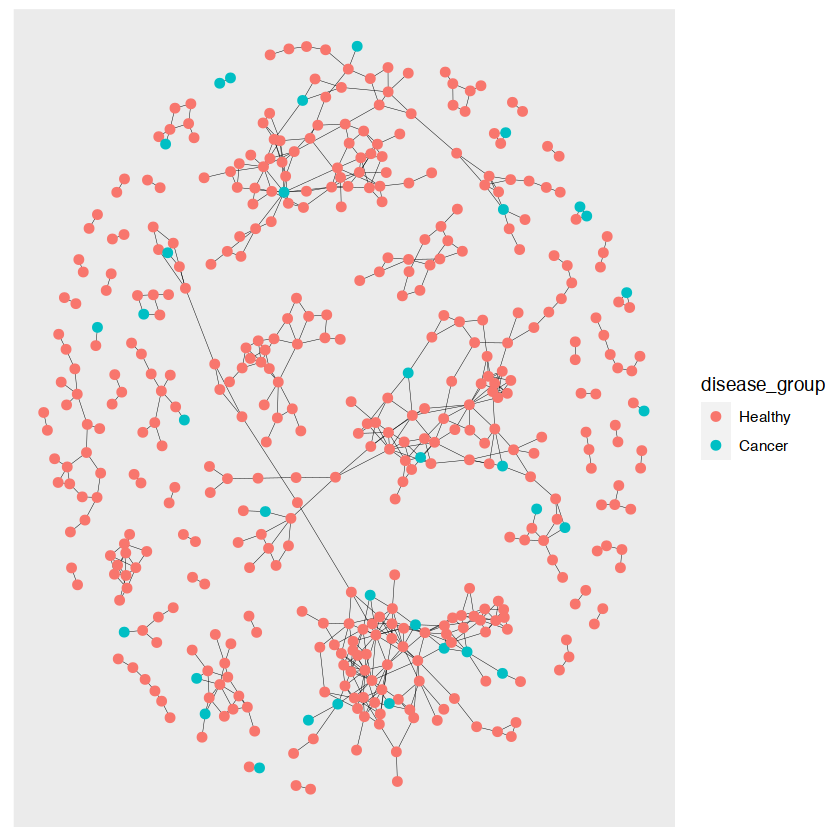

In [219]:
ggraph(myg1 , "fr", weights = NULL ) +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + 
geom_node_point(aes(color = disease_group), size = 2)

In [175]:
head(discovery_metadata)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>
Peds_Ctrl_2,Peds_Ctrl_2,NA,PBMC,Henderson,Child,Unknown,Peds healthy Control,Peds_Ctrl_2,Healthy
Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_3,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_3,Healthy
Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_5,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_5,Healthy
Peds_Febrile_Ctrl_6,Peds_Febrile_Ctrl_6,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_6,Healthy
Peds_Febrile_Ctrl_1,Peds_Febrile_Ctrl_1,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_1,Healthy
Peds_Ctrl_1,Peds_Ctrl_1,NA,PBMC,Henderson,Child,Unknown,Peds healthy Control,Peds_Ctrl_1,Healthy


In [180]:
head(discovery_metadata[ discovery_metadata$study == "Mitchell", ])

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>
310121_TCRB,Control 006,3,PBMC,Mitchell,Child,Female,Ctrl,310121_TCRB,Healthy
310186_TCRB,Control 012,12,PBMC,Mitchell,Adolescent,Male,Ctrl,310186_TCRB,Healthy
310222_TCRB,Control 016,3,PBMC,Mitchell,Child,Female,Ctrl,310222_TCRB,Healthy
310170_TCRB,Control 012,8,PBMC,Mitchell,Child,Male,Ctrl,310170_TCRB,Healthy
310193_TCRB,Control 011,19,PBMC,Mitchell,Young Adult,Female,Ctrl,310193_TCRB,Healthy
310268_TCRB,Control 019,1,PBMC,Mitchell,Neonate,Male,Ctrl,310268_TCRB,Healthy


In [178]:
discovery_metadata[ grepl("31013", discovery_metadata$Patient),]

Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>


In [136]:
tail(V(gliph_data_igrf)$disease)

[1] NA NA NA NA NA NA

In [132]:
head(metadata_matched)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>
310103_TCRB,Control 001,3,PBMC,Mitchell,Child,Female,Ctrl,310103_TCRB,Healthy
310104_TCRB,Control 002,1,PBMC,Mitchell,Neonate,Male,Ctrl,310104_TCRB,Healthy
310106_TCRB,Control 023,1,PBMC,Mitchell,Neonate,Male,Ctrl,310106_TCRB,Healthy
310108_TCRB,Control 015,0,PBMC,Mitchell,Neonate,Female,Ctrl,310108_TCRB,Healthy
310109_TCRB,Control 020,1,PBMC,Mitchell,Neonate,Male,Ctrl,310109_TCRB,Healthy
310111_TCRB,Control 020,2,PBMC,Mitchell,Child,Male,Ctrl,310111_TCRB,Healthy


## INT standalone

In [117]:
table(discovery_metadata$disease_group, useNA = "ifany")


Healthy  Cancer 
    456      77 

In [118]:
discovery_metadata <- discovery_metadata[ discovery_metadata$disease_group == "Cancer", ]

In [53]:
table(discovery_metadata$disease_group, useNA = "ifany")


Leukemia    Solid Lymphoma 
      36       28       13 

In [ ]:
discovery_metadata$disease_group[ discovery_metadata$disease == "Solid"] <- "Solid"
discovery_metadata$disease_group[ discovery_metadata$disease == "Leukemia"] <- "Leukemia"
discovery_metadata$disease_group[ discovery_metadata$disease == "Lymphoma"] <- "Lymphoma"

In [ ]:
table(discovery_metadata$disease_group, useNA = "ifany")


Leukemia Lymphoma    Solid 
      36       13       28 

In [ ]:
discovery_metadata$disease_group <- factor(discovery_metadata$disease_group, levels = c("Leukemia", "Solid", "Lymphoma"))

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [ ]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[5]))

In [ ]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [ ]:
head(onetest)

Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.y,Xpattern,hklust
<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<lgl>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
310102_TCRB:4586,450,S%GGNTE,5.3e-04,64,27,7.4e-09,1,1.00,0.290,...,TRBV04-01,TRBJ01-01,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4586,SXGGNTE,1
310102_TCRB:4586,199,SPG%NTE,1.2e-04,39,20,4.8e-08,1,1.00,0.600,...,TRBV04-01,TRBJ01-01,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4586,SPGXNTE,2
310102_TCRB:4687,138,SQG%NQP,8.1e-05,38,17,5.9e-09,1,0.82,0.076,...,TRBV20-01,TRBJ01-05,NA,NA,1.650533e-05,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4687,SQGXNQP,3
310102_TCRB:4705,101,R%NTE,4.1e-05,66,38,2.2e-09,1,0.84,0.079,...,TRBV06-06,TRBJ01-01,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4705,RXNTE,4
310102_TCRB:4745,428,S%SNQP,5.0e-04,60,24,1.9e-08,1,1.00,0.230,...,TRBV07-02,TRBJ01-05,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4745,SXSNQP,5
310102_TCRB:4745,428,S%SNQP,5.0e-04,60,24,1.9e-08,1,1.00,0.230,...,TRBV07-02,TRBJ01-05,NA,NA,8.252664e-06,P00461,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,4745,SXSNQP,5


In [ ]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(onetest %>% select(Xpattern, subject)))

In [ ]:
summary(discovery_metadata$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00   11.00   10.17   16.00   20.00 

In [ ]:
#discovery_metadata <- discovery_metadata[!is.na(discovery_metadata$Age), ]

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
# match metadata to the matrix
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
table(metadata_matched$disease)


Leukemia Lymphoma    Solid 
      13        4        7 

In [ ]:
summary(metadata_matched$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00   11.50   10.04   16.00   20.00 

Make rowData

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph
gliphdf$Class <- onetest$hklust[match(rownames(gliphdf), onetest$Xpattern)]

In [ ]:
head(gliphdf)

,gliph,Class
,<chr>,<int>
AX,AX,12
GQXG,GQXG,41
GRTAXYE,GRTAXYE,39
GTXEK,GTXEK,21
GXP,GXP,30
IPXTE,IPXTE,4


In [ ]:
gliphdf$Firstpattern <- NA
gliphdf$cluster_size <- NA
gliphdf$Patterns <- NA

for (i in 1:nrow(gliphdf)) {
    gliphdf$Firstpattern[i] <- onetest$Xpattern[onetest$hklust == gliphdf$Class[i]][1] # just the first pattern
    gliphdf$cluster_size[i] <- length(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]]) ) # cluster size
    gliphdf$Patterns[i] <- paste(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]] ) , collapse = ",")  # append all patterns for later inspection
}


In [ ]:
dim(gliphdf)

[1] 740   5

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
onetest_tse <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
set.seed(111)

In [ ]:
table(metadata_matched$disease_group, useNA = "ifany")


Leukemia    Solid Lymphoma 
      13        7        4 

In [ ]:
out <- ancombc2(
    data = onetest_tse, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "disease_group + Age", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "disease_group", 
    struc_zero = TRUE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 2, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


`tax_level` is not speficified 
No agglomeration will be performed
Otherwise, please speficy `tax_level` by one of the following: 
Class

Warning message:
"Small sample size detected for the following group(s): 
Lymphoma
Variance estimation would be unstable when the sample size is < 5 per group"
Obtaining initial estimates ...

ML iteration = 1, epsilon = 0.024

ML iteration = 2, epsilon = 2.9e-16

Estimating sample-specific biases ...

ANCOM-BC2 primary results ...

The sensitivity analysis for the pseudo-count addition ...

ANCOM-BC2 global test ...

ANCOM-BC2 pairwise directional test ...

ANCOM-BC2 Dunnet's type of test ...



In [ ]:
myres <- out$res

In [ ]:
colnames(myres)

[1] "taxon"                      "lfc_(Intercept)"           
 [3] "lfc_disease_groupSolid"     "lfc_disease_groupLymphoma" 
 [5] "se_(Intercept)"             "se_disease_groupSolid"     
 [7] "se_disease_groupLymphoma"   "W_(Intercept)"             
 [9] "W_disease_groupSolid"       "W_disease_groupLymphoma"   
[11] "p_(Intercept)"              "p_disease_groupSolid"      
[13] "p_disease_groupLymphoma"    "q_(Intercept)"             
[15] "q_disease_groupSolid"       "q_disease_groupLymphoma"   
[17] "diff_(Intercept)"           "diff_disease_groupSolid"   
[19] "diff_disease_groupLymphoma"

In [ ]:
(myres)

taxon,lfc_(Intercept),lfc_disease_groupSolid,lfc_disease_groupLymphoma,se_(Intercept),se_disease_groupSolid,se_disease_groupLymphoma,W_(Intercept),W_disease_groupSolid,W_disease_groupLymphoma,p_(Intercept),p_disease_groupSolid,p_disease_groupLymphoma,q_(Intercept),q_disease_groupSolid,q_disease_groupLymphoma,diff_(Intercept),diff_disease_groupSolid,diff_disease_groupLymphoma
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
SFXGNTE,-4.470904e-07,2.984928e-07,2.161374e-06,0.0001461902,0.0002471066,0.0003013789,-0.003058278,0.001207952,0.007171618,0.9975599,0.9990362,0.9942779,0.9975599,0.9990362,0.9942779,FALSE,FALSE,FALSE
SLGXE,2.443743e-02,-5.331872e-02,-5.331685e-02,0.0403855170,0.0682639831,0.0832568762,0.605103911,-0.781066574,-0.640389779,0.5451100,0.4347633,0.5219192,0.9975599,0.9990362,0.9942779,FALSE,FALSE,FALSE
SQGXE,-4.470904e-07,2.984928e-07,2.161374e-06,0.0001461902,0.0002471066,0.0003013789,-0.003058278,0.001207952,0.007171618,0.9975599,0.9990362,0.9942779,0.9975599,0.9990362,0.9942779,FALSE,FALSE,FALSE
SSXYE,-4.470904e-07,2.984928e-07,2.161374e-06,0.0001461902,0.0002471066,0.0003013789,-0.003058278,0.001207952,0.007171618,0.9975599,0.9990362,0.9942779,0.9975599,0.9990362,0.9942779,FALSE,FALSE,FALSE


In [ ]:
myres[ myres$diff_disease_groupCancer == "TRUE",]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


taxon,lfc_(Intercept),lfc_AgegroupChild,lfc_AgegroupAdolescent,lfc_AgegroupYoung Adult,lfc_AgegroupAdult,lfc_AgegroupSenior,lfc_disease_groupSolid,lfc_disease_groupLeukemia,lfc_disease_groupLymphoma,...,q_disease_groupLymphoma,diff_(Intercept),diff_AgegroupChild,diff_AgegroupAdolescent,diff_AgegroupYoung Adult,diff_AgegroupAdult,diff_AgegroupSenior,diff_disease_groupSolid,diff_disease_groupLeukemia,diff_disease_groupLymphoma
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


## hklust

In [19]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [20]:
filelist

[1] "gliphinput_int_adaptive_sample_01_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [2] "gliphinput_int_adaptive_sample_02_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [3] "gliphinput_int_adaptive_sample_03_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [4] "gliphinput_int_adaptive_sample_04_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [5] "gliphinput_int_adaptive_sample_05_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [6] "gliphinput_int_adaptive_sample_06_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [7] "gliphinput_int_adaptive_sample_07_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [8] "gliphinput_int_adaptive_sample_08_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
 [9] "gliphinput_int_adaptive_sample_09_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[10] "gliphinput_int_adaptive_sample_10_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[11] "gliphinput_int_adaptive_sample_11_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[12] "gliphinput_int_adaptive_sample_12_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[13] "gliphinput_int_adaptive_sample_13_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[14] "gliphinput_int_adaptive_sample_14_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[15] "gliphinput_int_adaptive_sample_15_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[16] "gliphinput_int_adaptive_sample_16_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[17] "gliphinput_int_adaptive_sample_17_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[18] "gliphinput_int_adaptive_sample_18_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[19] "gliphinput_int_adaptive_sample_19_cluster_gliph_rm_na_singlerm.rds_hklust.rds"
[20] "gliphinput_int_adaptive_sample_20_cluster_gliph_rm_na_singlerm.rds_hklust.rds"

In [21]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[4]))

In [24]:
head(onetest)

Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.y,Xpattern,hklust
<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<lgl>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
310102_TCRB:8815,259,SL%VGE,2.7e-04,18,14,3.0e-08,1,0.780,0.51,...,TRBV07-02,TRBJ02-02,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,8815,SLXVGE,1
310103_TCRB:10036,194,SE%GQP,1.6e-04,14,11,2.4e-09,1,0.079,0.12,...,TRBV10-01,TRBJ01-05,NA,NA,2.171435e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10036,SEXGQP,2
310103_TCRB:10088,165,S%RDSNQP,1.0e-04,20,13,2.1e-08,1,0.610,0.44,...,TRBV19-01,TRBJ01-05,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10088,SXRDSNQP,3
310103_TCRB:10106,217,S%GQGNEK,1.9e-04,29,14,6.7e-09,1,1.000,0.09,...,TRBV18-01,TRBJ01-04,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10106,SXGQGNEK,4
310103_TCRB:10224,307,SQQG%TE,3.1e-04,16,10,5.0e-08,1,0.740,0.22,...,TRBV16-01,TRBJ01-01,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10224,SQQGXTE,5
310103_TCRB:8882,100,SL%TE,5.3e-05,64,26,1.4e-08,1,1.000,0.38,...,TRBV11-02,TRBJ01-01,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,8882,SLXTE,6


In [23]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [25]:
onetest$hklust <- paste0("Cluster_", onetest$hklust)

In [26]:
head(onetest)

Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.y,Xpattern,hklust
<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<lgl>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
310102_TCRB:8815,259,SL%VGE,2.7e-04,18,14,3.0e-08,1,0.780,0.51,...,TRBV07-02,TRBJ02-02,NA,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,8815,SLXVGE,Cluster_1
310103_TCRB:10036,194,SE%GQP,1.6e-04,14,11,2.4e-09,1,0.079,0.12,...,TRBV10-01,TRBJ01-05,NA,NA,2.171435e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10036,SEXGQP,Cluster_2
310103_TCRB:10088,165,S%RDSNQP,1.0e-04,20,13,2.1e-08,1,0.610,0.44,...,TRBV19-01,TRBJ01-05,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10088,SXRDSNQP,Cluster_3
310103_TCRB:10106,217,S%GQGNEK,1.9e-04,29,14,6.7e-09,1,1.000,0.09,...,TRBV18-01,TRBJ01-04,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10106,SXGQGNEK,Cluster_4
310103_TCRB:10224,307,SQQG%TE,3.1e-04,16,10,5.0e-08,1,0.740,0.22,...,TRBV16-01,TRBJ01-01,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,10224,SQQGXTE,Cluster_5
310103_TCRB:8882,100,SL%TE,5.3e-05,64,26,1.4e-08,1,1.000,0.38,...,TRBV11-02,TRBJ01-01,NA,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,8882,SLXTE,Cluster_6


In [27]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(onetest %>% select(Xpattern, subject)))

In [28]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
# match metadata to the matrix
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [29]:
head(pat_type)

,310102_TCRB,310103_TCRB,310104_TCRB,310105_TCRB,310106_TCRB,310108_TCRB,310109_TCRB,310110_TCRB,310111_TCRB,310112_TCRB,...,Peds_COVID19_02,Peds_COVID19_08,Peds_COVID19_10,Peds_Ctrl_1,Peds_Ctrl_2,Peds_Ctrl_7,Peds_Febrile_Ctrl_2,Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_6
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GIWV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLAGAXYNE,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GRTGGXTE,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
GRXGG,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
GTGXYQP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTXNTE,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
head(metadata_matched)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>
310102_TCRB,Subject 001,3,PBMC,Mitchell,Child,Female,T1D,310102_TCRB,T1D
310103_TCRB,Control 001,3,PBMC,Mitchell,Child,Female,Ctrl,310103_TCRB,Healthy
310104_TCRB,Control 002,1,PBMC,Mitchell,Neonate,Male,Ctrl,310104_TCRB,Healthy
310105_TCRB,Subject 019,1,PBMC,Mitchell,Neonate,Male,T1D,310105_TCRB,T1D
310106_TCRB,Control 023,1,PBMC,Mitchell,Neonate,Male,Ctrl,310106_TCRB,Healthy
310108_TCRB,Control 015,0,PBMC,Mitchell,Neonate,Female,Ctrl,310108_TCRB,Healthy


Make rowData

In [31]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph
gliphdf$Class <- onetest$hklust[match(rownames(gliphdf), onetest$Xpattern)]

In [34]:
head(gliphdf)

,gliph,Class
,<chr>,<chr>
GIWV,GIWV,Cluster_57
GLAGAXYNE,GLAGAXYNE,Cluster_15
GRTGGXTE,GRTGGXTE,Cluster_65
GRXGG,GRXGG,Cluster_13
GTGXYQP,GTGXYQP,Cluster_63
GTXNTE,GTXNTE,Cluster_26


In [35]:
gliphdf$Firstpattern <- NA
gliphdf$cluster_size <- NA
gliphdf$Patterns <- NA

for (i in 1:nrow(gliphdf)) {
    gliphdf$Firstpattern[i] <- onetest$Xpattern[onetest$hklust == gliphdf$Class[i]][1] # just the first pattern
    gliphdf$cluster_size[i] <- length(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]]) ) # cluster size
    gliphdf$Patterns[i] <- paste(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]] ) , collapse = ",")  # append all patterns for later inspection
}


In [36]:
head(gliphdf)

,gliph,Class,Firstpattern,cluster_size,Patterns
,<chr>,<chr>,<chr>,<int>,<chr>
GIWV,GIWV,Cluster_57,GIWV,2,"GIWV,WVYE"
GLAGAXYNE,GLAGAXYNE,Cluster_15,GLAGAXYNE,2,"GLAGAXYNE,SIGGTXSYE"
GRTGGXTE,GRTGGXTE,Cluster_65,GRTGGXTE,1,GRTGGXTE
GRXGG,GRXGG,Cluster_13,SQXGG,18,"SQXGG,SQDXG,SFRDX,SERGX,SLAXL,GRXGG,SXDRG,SYRGX,SXLQG,SDLEX,SQDRX,SLRAX,SLXQG,XFRGE,SEAGX,SPDXG,SPXRG,SQSNX"
GTGXYQP,GTGXYQP,Cluster_63,GTGXYQP,1,GTGXYQP
GTXNTE,GTXNTE,Cluster_26,SLGGXE,55,"SLGGXE,SXMNTE,GTXNTE,SXSGSE,SXQNTE,SLXNTE,SLVGXE,SXDSTE,SXDRAE,SRGXTE,SXGNTE,SFXGTE,SAXNTE,SXRNTE,SXSNTE,SLRGXE,SLGXTE,SXGGTE,SQXGGE,SQNRXE,SQGXTE,SXQGTE,SXRGGE,SXPNTE,SFXNTE,SLXGGE,SEXGPE,SLXDTE,SLXGYE,SYXGGE,SQGXYE,SLDXTE,SYXGTE,SQVGXE,SXEGSE,SXGRTE,SDXNTE,SXWDTE,STQGXE,SQXGTE,SEXNTE,SQDXSE,SPQGXE,SIGXTE,SXGITE,SXRRTE,SQXRTE,STSXSE,SLDHXE,SXEGTE,SQXGAE,SLXSTE,SQGRXE,SWXGTE,XQGRTE"


Create TreeSummarizedExperiment to input to ANCOMBC

In [37]:
onetest_tse <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [38]:
set.seed(111)

In [39]:
out <- ancombc2(
    data = onetest_tse, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "Agegroup + Sex + disease_group", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "disease_group", 
    struc_zero = TRUE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 2, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


`tax_level` is not speficified 
No agglomeration will be performed
Otherwise, please speficy `tax_level` by one of the following: 
Class

Obtaining initial estimates ...

ML iteration = 1, epsilon = 0.069

ML iteration = 2, epsilon = 7.8e-15

Estimating sample-specific biases ...

ANCOM-BC2 primary results ...

The sensitivity analysis for the pseudo-count addition ...

ANCOM-BC2 global test ...

ANCOM-BC2 pairwise directional test ...

ANCOM-BC2 Dunnet's type of test ...



In [40]:
res = out$res

In [41]:
names(out)

[1] "feature_table"   "zero_ind"        "samp_frac"       "delta_em"       
 [5] "delta_wls"       "pseudo_sens_tab" "res"             "res_global"     
 [9] "res_pair"        "res_dunn"        "res_trend"

In [42]:
names(res)

[1] "taxon"                    "lfc_(Intercept)"         
 [3] "lfc_AgegroupChild"        "lfc_AgegroupAdolescent"  
 [5] "lfc_AgegroupYoung Adult"  "lfc_AgegroupAdult"       
 [7] "lfc_AgegroupSenior"       "lfc_AgegroupUnknown"     
 [9] "lfc_SexMale"              "lfc_SexUnknown"          
[11] "lfc_disease_groupViral"   "lfc_disease_groupCancer" 
[13] "lfc_disease_groupT1D"     "se_(Intercept)"          
[15] "se_AgegroupChild"         "se_AgegroupAdolescent"   
[17] "se_AgegroupYoung Adult"   "se_AgegroupAdult"        
[19] "se_AgegroupSenior"        "se_AgegroupUnknown"      
[21] "se_SexMale"               "se_SexUnknown"           
[23] "se_disease_groupViral"    "se_disease_groupCancer"  
[25] "se_disease_groupT1D"      "W_(Intercept)"           
[27] "W_AgegroupChild"          "W_AgegroupAdolescent"    
[29] "W_AgegroupYoung Adult"    "W_AgegroupAdult"         
[31] "W_AgegroupSenior"         "W_AgegroupUnknown"       
[33] "W_SexMale"                "W_SexUnknown"            
[35] "W_disease_groupViral"     "W_disease_groupCancer"   
[37] "W_disease_groupT1D"       "p_(Intercept)"           
[39] "p_AgegroupChild"          "p_AgegroupAdolescent"    
[41] "p_AgegroupYoung Adult"    "p_AgegroupAdult"         
[43] "p_AgegroupSenior"         "p_AgegroupUnknown"       
[45] "p_SexMale"                "p_SexUnknown"            
[47] "p_disease_groupViral"     "p_disease_groupCancer"   
[49] "p_disease_groupT1D"       "q_(Intercept)"           
[51] "q_AgegroupChild"          "q_AgegroupAdolescent"    
[53] "q_AgegroupYoung Adult"    "q_AgegroupAdult"         
[55] "q_AgegroupSenior"         "q_AgegroupUnknown"       
[57] "q_SexMale"                "q_SexUnknown"            
[59] "q_disease_groupViral"     "q_disease_groupCancer"   
[61] "q_disease_groupT1D"       "diff_(Intercept)"        
[63] "diff_AgegroupChild"       "diff_AgegroupAdolescent" 
[65] "diff_AgegroupYoung Adult" "diff_AgegroupAdult"      
[67] "diff_AgegroupSenior"      "diff_AgegroupUnknown"    
[69] "diff_SexMale"             "diff_SexUnknown"         
[71] "diff_disease_groupViral"  "diff_disease_groupCancer"
[73] "diff_disease_groupT1D"

In [43]:
rownames(res) <- res$taxon

In [45]:
res[,c("taxon", names(res)[grep("diff_", names(res))])]

,taxon,diff_(Intercept),diff_AgegroupChild,diff_AgegroupAdolescent,diff_AgegroupYoung Adult,diff_AgegroupAdult,diff_AgegroupSenior,diff_AgegroupUnknown,diff_SexMale,diff_SexUnknown,diff_disease_groupViral,diff_disease_groupCancer,diff_disease_groupT1D
,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
GXGNQP,GXGNQP,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
GXTE,GXTE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RGXE,RGXE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RGXGE,RGXGE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RXGQVNTE,RXGQVNTE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RXNTE,RXNTE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RXNTGE,RXNTGE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
RXSNQP,RXSNQP,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
SAXGTGE,SAXGTGE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [42]:
ls()

[1] "addjurkat.fx"       "age_pal"            "align_plots1"      
 [4] "cohort_col"         "cycle_col"          "datapath"          
 [7] "discovery_metadata" "filelist"           "gitpath"           
[10] "gliph_div.fx"       "gliphdf"            "group_col"         
[13] "h4hpath"            "histdenp"           "histp"             
[16] "i"                  "manifestpath"       "message_parallel"  
[19] "metadata_matched"   "myaxis"             "myplot"            
[22] "onetest"            "onetest_tse"        "out"               
[25] "pat_type"           "plotpath"           "res"               
[28] "safe_mclapply"      "text_matrix"        "type_col"          
[31] "zicoseq.fx"

In [56]:
table(gliphdf$Class)


 Cluster_1 Cluster_10 Cluster_11 Cluster_12 Cluster_13 Cluster_14 Cluster_15 
        29          6         33         18         18         15          2 
Cluster_16 Cluster_17 Cluster_18 Cluster_19  Cluster_2 Cluster_20 Cluster_21 
         9          5          4         12         18          7         19 
Cluster_22 Cluster_23 Cluster_24 Cluster_25 Cluster_26 Cluster_27 Cluster_28 
        15         11          4          3         55          3          9 
Cluster_29  Cluster_3 Cluster_30 Cluster_31 Cluster_32 Cluster_33 Cluster_34 
         4         16          4          2         17          4         25 
Cluster_35 Cluster_36 Cluster_37 Cluster_38 Cluster_39  Cluster_4 Cluster_40 
         7         14         17          2          9         10         10 
Cluster_41 Cluster_42 Cluster_43 Cluster_44 Cluster_45 Cluster_46 Cluster_47 
         2          5          1          3         14          6         13 
Cluster_48 Cluster_49  Cluster_5 Cluster_50 Cluster_51 Cluster_

In [65]:
gliphdf[ gliphdf$Class == "Cluster_5", ]

,gliph,Class,Firstpattern,cluster_size,Patterns
,<chr>,<chr>,<chr>,<int>,<chr>
SAQGXTE,SAQGXTE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,SXDRSTE,SPGXYTE,SQVXSTE,SPNXDTE,SIGXATE,SEXGHTE,SXRSNTE"
SDSXNTE,SDSXNTE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,SXDRSTE,SPGXYTE,SQVXSTE,SPNXDTE,SIGXATE,SEXGHTE,SXRSNTE"
SDXVSTE,SDXVSTE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,SXDRSTE,SPGXYTE,SQVXSTE,SPNXDTE,SIGXATE,SEXGHTE,SXRSNTE"
SERXNTE,SERXNTE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,SXDRSTE,SPGXYTE,SQVXSTE,SPNXDTE,SIGXATE,SEXGHTE,SXRSNTE"
SESGXYE,SESGXYE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,SXDRSTE,SPGXYTE,SQVXSTE,SPNXDTE,SIGXATE,SEXGHTE,SXRSNTE"
SETXNTE,SETXNTE,Cluster_5,SQQGXTE,78,"SQQGXTE,SXGQNTE,SXQGNTE,SLXENTE,SXSENTE,SSXGVTE,SPQGXTE,SQGAXTE,SXGANTE,SQGXNTE,SQXANTE,SIVXNTE,SPXVNTE,SLXMNTE,SLXANTE,SSXLNTE,SDSXNTE,SERXNTE,SEXRNTE,SXTVNTE,SXRGDTE,SKTGXTE,SXQMNTE,SEXENTE,SXQRNTE,SGQGXTE,SLAXNTE,SFXGNTE,SXGPNTE,SXQGRTE,SVQGXTE,SGXLNTE,SGQXNTE,SXDRRTE,SXRMNTE,SIXMNTE,SQVXNTE,SSQGXTE,SXDRDTE,SPSXNTE,SETXNTE,SPGGXTE,TXGGNTE,SFRXNTE,SFXQNTE,SXNMNTE,SLTXNTE,SQXLNTE,SXSPNTE,SLXPNTE,SQGXRTE,SDXVSTE,SSXRDRE,SXRANTE,SAQGXTE,SXDSYTE,SFPXNTE,SLXRRSE,SPGDXTE,SESGXYE,SXQGSTE,SYSXDTE,SLXQNTE,SXLSNTE,SEXGSTE,SGYXNTE,SFDRXTE,SQSXNTE,SPAXNTE,SXTRNTE,SXQSNTE,

In [45]:
gliphdf$Patterns[1]

[1] "GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,GIWV,WVYE,WVYE,GIWV,WVYE,GIWV,GIWV,WVYE,GIWV,WVYE,WVYE,WVYE,WVYE,WVYE,GIWV,WVYE,WVYE"

# Group similar TCR groups

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [ ]:
filelist

[1] "gliphinput_int_adaptive_sample_02_cluster_gliph_rm_na_singlerm.rds_hklust.rds"

In [ ]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[1]))

In [ ]:
dim(onetest)

[1] 12385    29

In [ ]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [ ]:
dim(onetest)

[1] 13538    29

In [ ]:
head(discovery_metadata)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Peds_Ctrl_2,Peds_Ctrl_2,NA,PBMC,Henderson,Child,Unknown,Peds healthy Control,Peds_Ctrl_2,Non-Cancer
MAS_3,MAS_3,NA,PBMC,Henderson,Child,Unknown,MAS,MAS_3,Non-Cancer
Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_3,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_3,Non-Cancer
KD_4,KD_4,NA,PBMC,Henderson,Child,Unknown,KD,KD_4,Non-Cancer
KD_3,KD_3,NA,PBMC,Henderson,Child,Unknown,KD,KD_3,Non-Cancer
sJIA_7,sJIA_7,NA,PBMC,Henderson,Child,Unknown,sJIA,sJIA_7,Non-Cancer


In [ ]:
onetest <- onetest[ onetest$subject %in% discovery_metadata$sample_name, ]

In [ ]:
onetest$hklust <- paste0("Cluster_", onetest$hklust)

In [ ]:
pat_type <- as.data.frame.matrix(table(onetest %>% select(hklust, subject)))

In [ ]:
head(pat_type)

,310103_TCRB,310104_TCRB,310105_TCRB,310106_TCRB,310108_TCRB,310109_TCRB,310110_TCRB,310111_TCRB,310113_TCRB,310114_TCRB,...,Peds_Ctrl_2,Peds_Ctrl_7,Peds_Febrile_Ctrl_1,Peds_Febrile_Ctrl_2,Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_6,sJIA_2,sJIA_4,sJIA_7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Cluster_1,2,5,20,8,3,4,0,5,1,5,...,0,4,2,1,3,1,4,1,1,0
Cluster_10,0,1,6,0,0,3,0,2,0,0,...,1,0,0,0,1,1,1,0,0,0
Cluster_11,0,2,2,1,0,0,0,0,0,1,...,1,1,0,0,0,0,2,0,0,0
Cluster_12,0,0,4,2,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
Cluster_13,0,0,6,2,0,0,0,2,0,0,...,0,3,0,0,0,0,0,0,0,0
Cluster_14,0,0,1,1,2,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0


In [ ]:
table(discovery_metadata$study, useNA = "ifany")


  Emerson Henderson INTERCEPT  Mitchell 
      654        25        91       203 

In [ ]:
table(discovery_metadata$disease)


                Ctrl    Cytomegalovirus +    Cytomegalovirus - 
                  94                  284                  346 
     Emerson_unknown                   KD                  LFS 
                  24                    4                    6 
            Leukemia             Lymphoma                  MAS 
                  36                   13                    3 
   MIS-C SARSCoV2Neg    MIS-C SARSCoV2Pos               Normal 
                   2                    2                    8 
        Peds COVID19 Peds febrile Control Peds healthy Control 
                   3                    5                    3 
               Solid                  T1D                 sJIA 
                  28                  109                    3 

In [ ]:
discovery_metadata[ discovery_metadata$Agegroup == "Years" ,]

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P00612,P00612,NA,PBMC,Emerson,Years,Female,Cytomegalovirus -,P00612,Non-Cancer
P00614,P00614,NA,PBMC,Emerson,Years,Female,Cytomegalovirus -,P00614,Non-Cancer


In [ ]:
table(discovery_metadata$Agegroup, useNA = "ifany")



 Adolescent       Adult       Child     Neonate     Unknown       Years 
         35         431         272          35         159           2 
Young Adult 
         39 

In [ ]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [ ]:
head(discovery_metadata)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Peds_Ctrl_2,Peds_Ctrl_2,NA,PBMC,Henderson,Child,Unknown,Peds healthy Control,Peds_Ctrl_2,Non-Cancer
MAS_3,MAS_3,NA,PBMC,Henderson,Child,Unknown,MAS,MAS_3,Non-Cancer
Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_3,NA,PBMC,Henderson,Child,Unknown,Peds febrile Control,Peds_Febrile_Ctrl_3,Non-Cancer
KD_4,KD_4,NA,PBMC,Henderson,Child,Unknown,KD,KD_4,Non-Cancer
KD_3,KD_3,NA,PBMC,Henderson,Child,Unknown,KD,KD_3,Non-Cancer
sJIA_7,sJIA_7,NA,PBMC,Henderson,Child,Unknown,sJIA,sJIA_7,Non-Cancer


Zicoseq

In [ ]:
   #pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
   metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
mytest <- ZicoSeq(
    meta.dat = metadata_matched, feature.dat = as.matrix(pat_type),
    grp.name = "disease_group", adj.name = c("Agegroup", "study", "Sex"), feature.dat.type = "count",
    # Filter to remove rare taxa
    prev.filter = 0.01, mean.abund.filter = 0,
    max.abund.filter = 0, min.prop = 0,
    # Winsorization to replace outliers
    is.winsor = FALSE, # outlier.pct = 0.03, winsor.end = 'top',
    # Posterior sampling
    is.post.sample = TRUE, post.sample.no = 25,
    # Use the square-root transformation
    link.func = list(function(x) x^0.5), stats.combine.func = max,
    # Permutation-based multiple testing correction
    perm.no = 99, strata = NULL,
    # Reference-based multiple stage normalization
    ref.pct = 0.5, stage.no = 6, excl.pct = 0.2,
    # Family-wise error rate control
    is.fwer = TRUE, verbose = TRUE, return.feature.dat = TRUE
)


5  features are filtered!
The data has  831  samples and  30  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!


In [ ]:
r2_fdr <- as.data.frame(mytest$R2)
r2_fdr$padj <- mytest$p.adj.fdr[match(rownames(r2_fdr), names(mytest$p.adj.fdr))]
r2_fdr$p <- mytest$p.raw[match(rownames(r2_fdr), names(mytest$p.raw))]

In [ ]:
r2_fdr

,Func1,padj,p
,<dbl>,<dbl>,<dbl>
Cluster_1,0.0006917645,0.3737374,0.19
Cluster_10,0.0009588398,0.4361260,0.19
Cluster_11,0.0012493345,0.4361260,0.22
Cluster_12,0.0003068340,0.8899338,0.95
Cluster_13,0.0010955238,0.5025253,0.45
Cluster_14,0.0002887832,0.8899338,0.94
Cluster_15,0.0016584815,0.3737374,0.09
Cluster_16,0.0002696692,0.9441077,0.74
Cluster_17,0.0004963742,0.8298990,0.78


In [ ]:
onetest[ onetest$hklust %in% c("Cluster_4","Cluster_5"), c("Xpattern", "subject", "hklust")]

Xpattern,subject,hklust
<chr>,<chr>,<chr>
SPRXGE,310103_TCRB,Cluster_4
SXVGDE,310103_TCRB,Cluster_4
SFXNTE,310104_TCRB,Cluster_4
SGXQNTE,310104_TCRB,Cluster_5
SXRDTE,310104_TCRB,Cluster_4
SLLGXTE,310104_TCRB,Cluster_5
SQGXNTE,310104_TCRB,Cluster_5
SEXQGTE,310104_TCRB,Cluster_5
SXGGTE,310104_TCRB,Cluster_4


# GLIPH groups

In [13]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds", full.names = FALSE)
# remove *.sh
filelist <- filelist[!grepl("sh", filelist)]
# remove *.out
filelist <- filelist[!grepl("out", filelist)]
# remove *hklust.rds
filelist <- filelist[!grepl("hklust", filelist)]

In [14]:
filelist

[1] "gliphinput_int_adaptive_sample_01_cluster_gliph_rm_na_singlerm.rds"
 [2] "gliphinput_int_adaptive_sample_02_cluster_gliph_rm_na_singlerm.rds"
 [3] "gliphinput_int_adaptive_sample_03_cluster_gliph_rm_na_singlerm.rds"
 [4] "gliphinput_int_adaptive_sample_04_cluster_gliph_rm_na_singlerm.rds"
 [5] "gliphinput_int_adaptive_sample_05_cluster_gliph_rm_na_singlerm.rds"
 [6] "gliphinput_int_adaptive_sample_06_cluster_gliph_rm_na_singlerm.rds"
 [7] "gliphinput_int_adaptive_sample_07_cluster_gliph_rm_na_singlerm.rds"
 [8] "gliphinput_int_adaptive_sample_08_cluster_gliph_rm_na_singlerm.rds"
 [9] "gliphinput_int_adaptive_sample_09_cluster_gliph_rm_na_singlerm.rds"
[10] "gliphinput_int_adaptive_sample_10_cluster_gliph_rm_na_singlerm.rds"
[11] "gliphinput_int_adaptive_sample_11_cluster_gliph_rm_na_singlerm.rds"
[12] "gliphinput_int_adaptive_sample_12_cluster_gliph_rm_na_singlerm.rds"
[13] "gliphinput_int_adaptive_sample_13_cluster_gliph_rm_na_singlerm.rds"
[14] "gliphinput_int_adaptive_sample_14_cluster_gliph_rm_na_singlerm.rds"
[15] "gliphinput_int_adaptive_sample_15_cluster_gliph_rm_na_singlerm.rds"
[16] "gliphinput_int_adaptive_sample_16_cluster_gliph_rm_na_singlerm.rds"
[17] "gliphinput_int_adaptive_sample_17_cluster_gliph_rm_na_singlerm.rds"
[18] "gliphinput_int_adaptive_sample_18_cluster_gliph_rm_na_singlerm.rds"
[19] "gliphinput_int_adaptive_sample_19_cluster_gliph_rm_na_singlerm.rds"
[20] "gliphinput_int_adaptive_sample_20_cluster_gliph_rm_na_singlerm.rds"

In [15]:
mylist <- lapply(filelist, function(x){ gliph_div.fx(datapath, h4hpath, x )})

In [16]:
head(mylist[[1]])

,310102_TCRB,310103_TCRB,310104_TCRB,310105_TCRB,310106_TCRB,310108_TCRB,310109_TCRB,310110_TCRB,310111_TCRB,310112_TCRB,...,Peds_Ctrl_1,Peds_Ctrl_2,Peds_Ctrl_7,Peds_Febrile_Ctrl_1,Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_6,sJIA_2,sJIA_4,sJIA_7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
global-%AG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%AGTE,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%ENTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%GE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#mylist <- lapply(mylist, function(x) as.data.frame(x))

ZicoSeq

In [116]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [119]:
lapply(mylist, function(x) dim(x))

[[1]]
[1] 756 813

[[2]]
[1] 704 824

[[3]]
[1] 727 822

[[4]]
[1] 711 820

[[5]]
[1] 740 819

[[6]]
[1] 763 828

[[7]]
[1] 738 814

[[8]]
[1] 748 811

[[9]]
[1] 693 814

[[10]]
[1] 666 802

[[11]]
[1] 764 817

[[12]]
[1] 733 823

[[13]]
[1] 772 817

[[14]]
[1] 748 801

[[15]]
[1] 761 827

[[16]]
[1] 709 816

[[17]]
[1] 760 820

[[18]]
[1] 679 824

[[19]]
[1] 679 826

[[20]]
[1] 811 820

In [20]:
# get number of zero for each row in each matrix
mylist_5 <- lapply(mylist, \(x) { x[rowSums(x != 0) > 9  , ] })
mylist_5 <- lapply(mylist_5, \(x) { x[ ,colSums(x != 0) > 1   ] })


In [21]:
zicolist  <- lapply(mylist_5, \(x) {zicoseq.fx(as.matrix(x), discovery_metadata, "disease_group")} )

0  features are filtered!
The data has  730  samples and  446  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  729  samples and  407  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  744  samples and  425  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  713  samples and  384  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  721  samples and  41

In [22]:
length(zicolist)

[1] 20

In [23]:
dfColList <- lapply(zicolist ,rownames)
commonCols <- Reduce(intersect,dfColList)

In [24]:
commonCols

[1] "global-%E"      "global-S%"      "global-S%GGE"   "global-S%GTE"  
 [5] "global-S%NTE"   "global-S%QGNTE" "global-SE%GE"   "global-SL%GE"  
 [9] "global-SLG%E"   "global-SQ%GE"

In [25]:
zicolist <- lapply(zicolist ,\(x) x[  order(x$padj, decreasing = F),])

In [26]:
lapply(zicolist , head)

,Func1,padj
,<dbl>,<dbl>
global-S%GNEK,0.06690115,0.07070707
global-S%DSGANV,0.04017443,0.13019080
global-S%GGNT,0.02649754,0.13019080
global-S%GTGGTE,0.02619123,0.13019080
global-SESG%TE,0.02764503,0.13019080
global-SL%GGE,0.02687032,0.13019080
,Func1,padj
,<dbl>,<dbl>
global-%GE,0.03683816,0.0523416


A lot of these TCR groups are highly similar, for example global-SE%RNTE, global-SET%NTE. Let's group them together based on PID on H4H and rerun zicoseq

In [225]:
which(mytest$p.raw < 0.1)

Cluster_15 Cluster_19 Cluster_20 Cluster_29  Cluster_3  Cluster_4  Cluster_5 
         7         11         13         21         22         25         26 
 Cluster_9 
        30

In [228]:
head(metadata_matched)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
310103_TCRB,Control 001,3,PBMC,Mitchell,Child,Female,Ctrl,310103_TCRB,Non-Cancer
310104_TCRB,Control 002,1,PBMC,Mitchell,Neonate,Male,Ctrl,310104_TCRB,Non-Cancer
310105_TCRB,Subject 019,1,PBMC,Mitchell,Neonate,Male,T1D,310105_TCRB,Non-Cancer
310106_TCRB,Control 023,1,PBMC,Mitchell,Neonate,Male,Ctrl,310106_TCRB,Non-Cancer
310108_TCRB,Control 015,0,PBMC,Mitchell,Neonate,Female,Ctrl,310108_TCRB,Non-Cancer
310109_TCRB,Control 020,1,PBMC,Mitchell,Neonate,Male,Ctrl,310109_TCRB,Non-Cancer


In [230]:
names(mytest)

[1] "call"            "feature.dat"     "filter.features" "ref.features"   
 [5] "R2"              "F0"              "RSS"             "df.model"       
 [9] "df.residual"     "coef.list"       "p.raw"           "p.adj.fdr"      
[13] "p.adj.fwer"

In [258]:
mytest$p.adj.fdr

Cluster_1 Cluster_10 Cluster_11 Cluster_12 Cluster_13 Cluster_14 Cluster_15 
 0.3737374  0.4361260  0.4361260  0.8899338  0.5025253  0.8899338  0.3737374 
Cluster_16 Cluster_17 Cluster_18 Cluster_19  Cluster_2 Cluster_20 Cluster_21 
 0.9441077  0.8298990  0.8574635  0.2289562  0.6115320  0.2289562  0.4805954 
Cluster_23 Cluster_24 Cluster_25 Cluster_26 Cluster_27 Cluster_28 Cluster_29 
 0.6115320  0.8574635  0.6115320  0.4805954  0.6115320  0.3737374  0.1582492 
 Cluster_3 Cluster_30 Cluster_33  Cluster_4  Cluster_5  Cluster_6  Cluster_7 
 0.2289562  0.3737374  0.3737374  0.1363636  0.1363636  0.4361260  0.4361260 
 Cluster_8  Cluster_9 
 0.3737374  0.3737374

In [255]:
(r2_fdr)

,Func1,padj,p
,<dbl>,<dbl>,<dbl>
Cluster_1,0.0006917645,0.3737374,0.19
Cluster_10,0.0009588398,0.4361260,0.19
Cluster_11,0.0012493345,0.4361260,0.22
Cluster_12,0.0003068340,0.8899338,0.95
Cluster_13,0.0010955238,0.5025253,0.45
Cluster_14,0.0002887832,0.8899338,0.94
Cluster_15,0.0016584815,0.3737374,0.09
Cluster_16,0.0002696692,0.9441077,0.74
Cluster_17,0.0004963742,0.8298990,0.78


In [253]:
p <- ggplot(r2_fdr, aes(x=Func1, y=-log10(padj))) +
    geom_point(size=2.5) +
    #scale_colour_manual(values = c("Down-regulated"= "blue", "Up-regulated"="red",  "not significant"= "black")) +    

    myplot + myaxis +
    theme(axis.text.x = element_text(size = 30, angle = 0, hjust = 0.5),
          axis.title = element_text(size = 30), axis.text.y = element_text(size = 30),
          plot.title = element_text(size = 30, hjust = 0.5), legend.position = "none") + 
    labs(x = "R2" ,y = "p-value (-Log10)") 

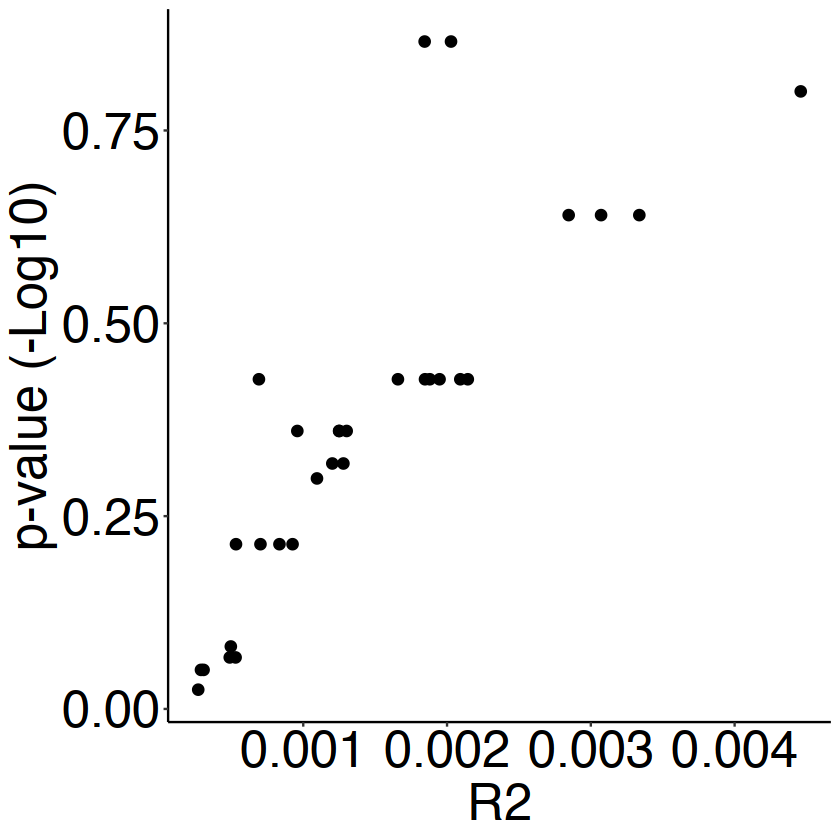

In [254]:
p

# Backup

In [246]:
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [247]:
head(metadata_matched)

,Patient,Age,sampletype,study,Agegroup,Sex,disease,sample_name,disease_group
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
310103_TCRB,Control 001,3,PBMC,Mitchell,Child,Female,Ctrl,310103_TCRB,Non-Cancer
310104_TCRB,Control 002,1,PBMC,Mitchell,Neonate,Male,Ctrl,310104_TCRB,Non-Cancer
310105_TCRB,Subject 019,1,PBMC,Mitchell,Neonate,Male,T1D,310105_TCRB,Non-Cancer
310106_TCRB,Control 023,1,PBMC,Mitchell,Neonate,Male,Ctrl,310106_TCRB,Non-Cancer
310108_TCRB,Control 015,0,PBMC,Mitchell,Neonate,Female,Ctrl,310108_TCRB,Non-Cancer
310109_TCRB,Control 020,1,PBMC,Mitchell,Neonate,Male,Ctrl,310109_TCRB,Non-Cancer


In [248]:
dds <- DESeqDataSetFromMatrix( as.matrix(pat_type) + 1, colData = metadata_matched, 
                                design = ~ study + Sex + disease_group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [249]:
dds <- DESeq(dds, parallel = TRUE)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates: 2 workers

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in lfproc(x, y, weig

In [251]:
res <- as.data.frame(results(dds, contrast= c("disease_group", "Cancer", "Non-Cancer")))

In [252]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cluster_1,5.171391,0.746292096,0.5959950,1.252178488,0.2105048,0.9970335
Cluster_10,1.773875,0.452919093,0.6013632,0.753154000,0.4513574,0.9970335
Cluster_11,1.359895,0.223923978,0.5659820,0.395637967,0.6923721,0.9970335
Cluster_12,1.369732,0.307815344,0.6488599,0.474394156,0.6352189,0.9970335
Cluster_13,1.194564,0.260532646,0.6498945,0.400884532,0.6885051,0.9970335
Cluster_14,1.593543,0.301196839,0.6031297,0.499389793,0.6175048,0.9970335
Cluster_15,1.156278,-0.168221488,0.6187854,-0.271857578,0.7857315,0.9970335
Cluster_16,1.060704,-0.061350791,0.6622475,-0.092640276,0.9261893,0.9970335
Cluster_17,1.288355,-0.010714648,0.6130693,-0.017477058,0.9860560,0.9970335


In [154]:
head(onetest)

,Sample,index.x,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,...,TcRa,Freq,CDR3b,TRBV,TRBJ,count,clonefraction,subject,file,index.y
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>
1,310102_TCRB:6569,213,SDL%T,1.6e-04,7,7,3.0e-09,1,0.005,0.700,...,NA,0,CATSDLETQYF,TRBV24-01,TRBJ02-05,NA,8.252664e-06,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,6569
2,310102_TCRB:6579,161,S%GESQP,8.7e-05,5,5,6.4e-07,1,0.460,0.960,...,NA,0,CSASGGESQPQHF,TRBV20-01,TRBJ01-05,NA,1.650533e-05,310102_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310102_TCRB.tsv,6579
3,310103_TCRB:6665,171,S%RDNTE,8.8e-05,10,8,1.5e-08,1,0.130,0.130,...,NA,0,CASSIRDNTEAFF,TRBV19-01,TRBJ01-01,NA,1.085717e-05,310103_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310103_TCRB.tsv,6665
4,310104_TCRB:6701,16,S%SGNT,2.4e-07,49,26,1.4e-09,1,1.000,0.036,...,NA,0,CASSPSGNTIYF,TRBV14-01,TRBJ01-03,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6701
5,310104_TCRB:6708,251,S%GQP,2.1e-04,23,15,6.2e-08,1,0.990,0.660,...,NA,0,CASSTGQPQHF,TRBV19-01,TRBJ01-05,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6708
6,310104_TCRB:6734,179,SLA%E,9.4e-05,46,25,6.8e-10,1,0.190,0.070,...,NA,0,CASSLAEEQFF,TRBV07-08,TRBJ02-01,NA,5.449324e-06,310104_TCRB,/cluster/projects/pughlab/projects/INTERCEPT/Adaptive/Mitchell_Michels2022/310104_TCRB.tsv,6734


In [180]:
aln.fx <- function(x) {

    mygroups <- gsub("%", "X", unique(x$pattern))
    mymat <- matrix(0,
        nrow = length(mygroups), ncol = length(mygroups),
        dimnames = list(mygroups, mygroups)
    )
    D <- combn(length(mygroups), 2)

    for (i in 1:ncol(D)) {
        aln <- pairwiseAlignment(
            rownames(mymat)[D[1, i]],
            rownames(mymat)[D[2, i]],
            substitutionMatrix = BLOSUM62, gapOpening = -2, gapExtension = -10)
        # print(aln)
        mymat[D[1, i], D[2, i]] <- score(aln)
        mymat[D[2, i], D[1, i]] <- score(aln)
    }
    return(mymat)
}


In [181]:
mm <- aln.fx(onetest[1:50,])

In [182]:
dist_mat <- dist(mymat, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
cut_avg <- cutree(hclust_avg, h = quantile(dist_mat,0.25))


In [183]:
onetest1 <- onetest[1:50,]

In [193]:
mygroups <- gsub("%", "X", unique(onetest1$pattern))
    mymat <- matrix(0,
        nrow = length(mygroups), ncol = length(mygroups),
        dimnames = list(mygroups, mygroups))

In [196]:
D <- combn(length(mygroups), 2)

    for (i in 1:ncol(D)) {
        aln <- pairwiseAlignment(
            rownames(mymat)[D[1, i]],
            rownames(mymat)[D[2, i]],
            substitutionMatrix = BLOSUM62, gapOpening = -2, gapExtension = -10)
        # print(aln)
        mymat[D[1, i], D[2, i]] <- score(aln)
        mymat[D[2, i], D[1, i]] <- score(aln)
    }

In [244]:
dist_mat <- dist(mymat, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
cut_avg <- dendextend::cutree(hclust_avg, h = quantile(dist_mat,0.1))

In [230]:
names(hclust_avg)

[1] "merge"       "height"      "order"       "labels"      "method"     
[6] "call"        "dist.method"

In [231]:
names(cut_avg)

[1] "SDLXT"     "SXGESQP"   "SXRDNTE"   "SXSGNT"    "SXGQP"     "SLAXE"    
 [7] "SGQGXGE"   "SPX"       "XGNTE"     "SDXGQP"    "SQGXNTE"   "SXHTGE"   
[13] "SLXTGE"    "SXGYTE"    "SXGDT"     "SLGXE"     "SPXRG"     "SXEQGRE"  
[19] "SLXGTGE"   "SLGGSXTE"  "SXSNQP"    "RGTXDYE"   "SXGQNYG"   "SXNTE"    
[25] "XQNTE"     "SLXGAGANV" "RXDRE"     "SFXGNT"    "SLDXGNT"   "SLXSGNT"  
[31] "SLVGGXTE"  "XAGTE"     "SLQGXNTE"  "SXSGQP"    "SEXYE"     "SXAYE"    
[37] "SXANTE"    "SLXGSGNT"  "SXGVGTE"   "SLXDQP"    "SLGQGXTE"  "SXGQGNQP" 
[43] "SXSSYNSP"  "SLGLX"     "SFXGE"     "SLEGXGE"   "SXADT"     "SEXGE"    
[49] "SXPGQP"    "SEXGTGE"

In [232]:
onetest1$pattern1 <- gsub("%", "X", onetest1$pattern)

In [233]:
onetest1$hk <- cut_avg[match(onetest1$pattern1, names(cut_avg))]

In [236]:
(table(cut_avg))

cut_avg
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 
12  2  2  2  1  6  1  4  5  4  4  1  1  2  1  1  1 

In [239]:
library(dendextend)
row_dend = as.dendrogram(hclust_avg)
row_dend = color_branches(row_dend, k = length((table(cut_avg)))) 
hm <- ComplexHeatmap::Heatmap(mymat, name = "mat", 
cluster_rows = row_dend, row_dend_width = unit(4, "cm"))

In [240]:
pdf(paste0(plotpath, "test.pdf"), width = 10, height = 10)
hm
dev.off()

pdf 
  2

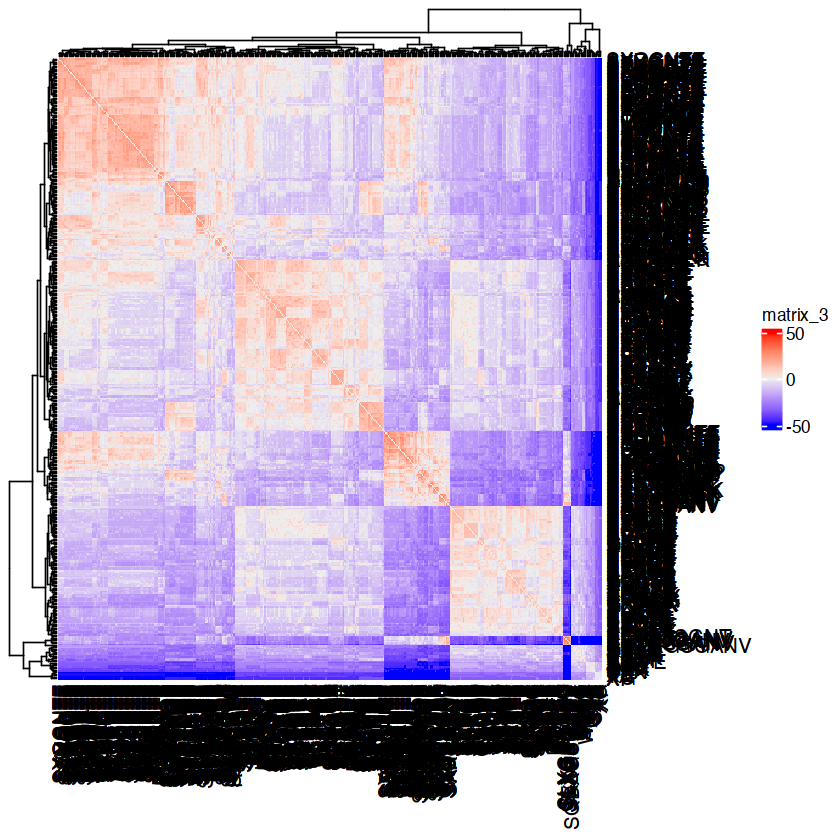

In [109]:
ComplexHeatmap::Heatmap(mymat)

In [148]:
head(onetest)

,310104_TCRB,310106_TCRB,310108_TCRB,310109_TCRB,310110_TCRB,310111_TCRB,310113_TCRB,310114_TCRB,310117_TCRB,310118_TCRB,...,P00667,P00668,Peds_COVID19_08,Peds_Ctrl_1,Peds_Ctrl_2,Peds_Ctrl_7,Peds_Febrile_Ctrl_3,Peds_Febrile_Ctrl_5,Peds_Febrile_Ctrl_6,sJIA_2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
global-%AGTE,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%ENTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%GE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
global-%GEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
volcano.fx <- function(resdf, fc, padj, ttl){
    
    # remove padj = NA
    
    resdf <- resdf[ !is.na(resdf$padj),]
    
    resdf$threshold <- NA
    resdf$threshold[ resdf$log2FoldChange > fc & resdf$padj < padj] <- "Up-regulated"
    resdf$threshold[ resdf$log2FoldChange < -fc & resdf$padj < padj] <- "Down-regulated"
    resdf$threshold[ is.na(resdf$threshold)] <- "not significant"
    
res_upreg <- resdf[ resdf$threshold == "Up-regulated",]    
res_upreg <- res_upreg[order(res_upreg$log2FoldChange, decreasing = T),]    
res_downreg <- resdf[ resdf$threshold == "Down-regulated",]    
res_downreg <- res_downreg[order(res_downreg$log2FoldChange, decreasing = F),]  

if(nrow(res_upreg) < 10){
    resdf$genelabels[ rownames(resdf) %in% rownames(res_upreg)] <- "UP"}
if(nrow(res_downreg) < 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)] <- "DOWN"}    

if(nrow(res_upreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_upreg)[1:10]] <- "UP"   }
if(nrow(res_downreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)[1:10]] <- "DOWN" } 
    
    p <- ggplot(resdf, aes(x=log2FoldChange, y=-log10(pvalue))) +
    geom_point(aes(color = threshold), size=2.5) +
    scale_colour_manual(values = c("Down-regulated"= "blue", "Up-regulated"="red",  "not significant"= "black")) +    
    geom_text_repel(data = subset(resdf, genelabels == "UP"),
                    label = subset(resdf, genelabels == "UP")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf,  min.segment.length = 0,
                    direction = "both", nudge_x = 3, nudge_y = 0.5, vjust = 0.5, hjust = 0.5) + 
    geom_text_repel(data = subset(resdf, genelabels == "DOWN"),
                    label = subset(resdf, genelabels == "DOWN")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf, direction = "both", 
                    nudge_x = -3, nudge_y = 0.5,
                    vjust = 0.5, hjust = 0.5, min.segment.length = 0) + 
    myplot + myaxis +
    theme(axis.text.x = element_text(size = 30, angle = 0, hjust = 0.5),
          axis.title = element_text(size = 30), axis.text.y = element_text(size = 30),
          plot.title = element_text(size = 30, hjust = 0.5), legend.position = "none") + 
    labs(x = "Fold change (Log2)" ,y = "p-value (-Log10)", title = ttl)     
    
    return(p)
}